In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Prepare a toy dataset

In [3]:
## Dataset

data = np.genfromtxt('perceptron_toydata.txt', delimiter='\t')
X, y = data[:,:2], data[:,2]
y = y.astype(int)

print('Class label countr:', np.bincount(y))
print('X.shape', X.shape)
print('y.shape', y.shape)

Class label countr: [50 50]
X.shape (100, 2)
y.shape (100,)


In [4]:
# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

In [5]:
# Normalize
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu)/sigma
X_test = (X_test - mu)/sigma

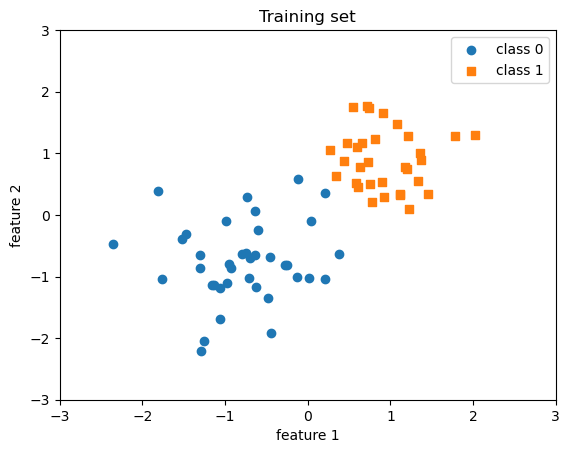

In [6]:
plt.scatter(X_train[y_train==0,0], X_train[y_train==0,1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend()
plt.show()

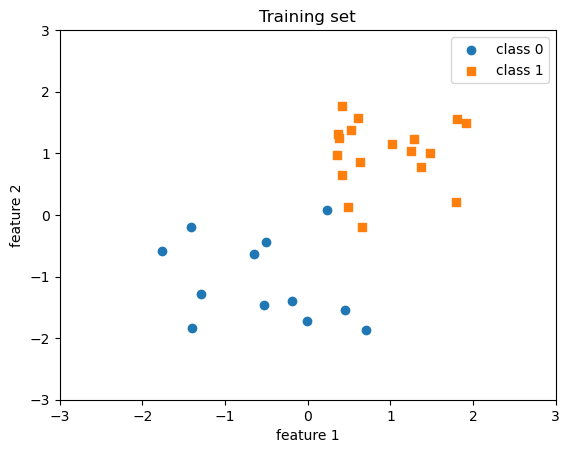

In [7]:
plt.scatter(X_test[y_test==0,0], X_test[y_test==0,1], label='class 0', marker='o')
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3,3])
plt.ylim([-3,3])
plt.legend()
plt.show()

## Define the Perceptron model

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [14]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + (~(cond) * x_2)
    
class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros((num_features, 1), dtype=torch.float, device=device)
        self.bias = torch.zeros(1, dtype=torch.float, device=device)
        
    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        prediction = custom_where(linear > 0., 1, 0).float()
        return prediction
        
    def backward(self, x, y):
        prediction = self.forward(x)
        errors = y - prediction
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
        
    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y) / y.shape[0]
        return accuracy
        

## Training the perceptron

In [15]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
                              
ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model prarameters:\n\n')
print(' Weights: %s\n' % ppn.weights)
print(' Biases: %s\n' %ppn.bias)

Model prarameters:


 Weights: tensor([[1.2734],
        [1.3464]])

 Biases: tensor([-1.])



## Evaluation

In [18]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 93.33%


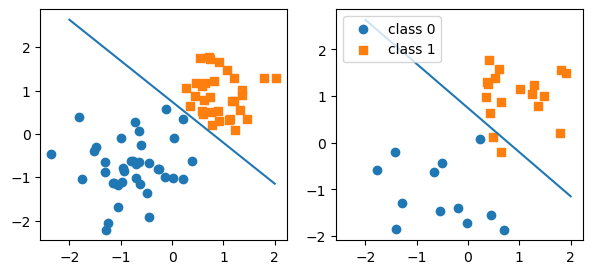

In [19]:
# Decision Boundary

w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()